In [13]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\Ferna\AppData\Local\Temp\ipykernel_16772\598901921.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Full_Strategy
 1.0    2097
-1.0    1684
-2.0     698
 2.0     432
 0.0     156
Name: count, dtype: int64

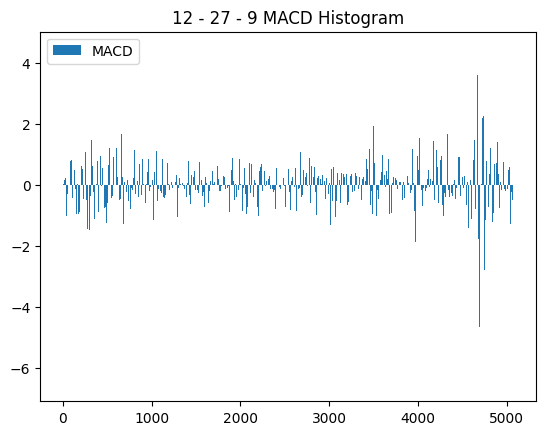

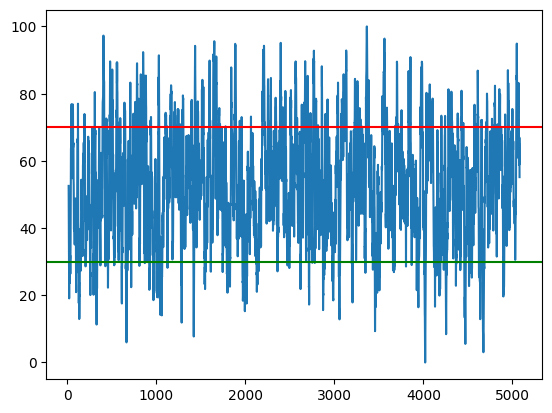

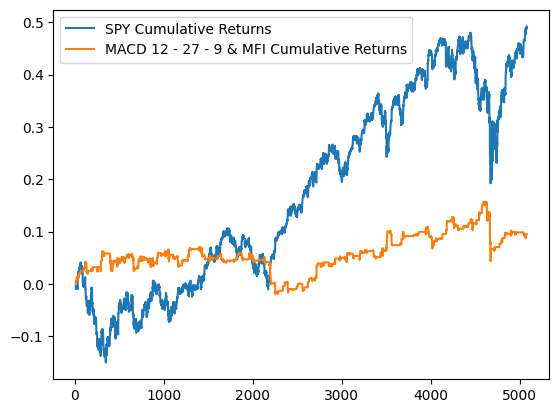

In [17]:
TICKER = 'SPY'
INTERVAL = '1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# MACD parameters
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# MFI parameters
MFI_LENGHT = 14
OVERBOUGHT = 70 
OVERSOLD = 30

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f'{fast}_ema'] = df['Close'].ewm(span = fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span = slow).mean()

    df['MACD'] = df[f'{slow}_ema'] - df[f'{fast}_ema']

    df['Signal'] = df['MACD'].ewm(span = span).mean()

    #Part 2
    df['MACD_hist'] = df['MACD'] - df['Signal']

    #Plot
    plt.bar(x = df.index, height=df['MACD_hist']) 

    #for the bar graph make sure to define the indexes. The x index is a time index that is set by default on yfinance 
    plt.legend(['MACD', 'Signal'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):
    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)

    return df

def add_MFI(df, lenght = MFI_LENGHT):

    #Typical/Average Price
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']

    #initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Money_Flow'], 0)

    mfr = df['Pos_Flow'].rolling(lenght).sum() / df['Neg_Flow'].rolling(lenght).sum()
    df['MFI'] = 100 - (100 / (1 + mfr))

    return df.dropna()

def add_MFI_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, np.where(df['MFI'] < oversold, 1, 0))
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green')

    return df

def add_full_strategy(df):
    df['Full_Strategy'] = df['MACD_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    plt.legend([f'{TICKER} Cumulative Returns', f'MACD {MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} & MFI Cumulative Returns'])

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MACD_strategy(df)
    df = add_MFI(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    
    return df

df = main()
df['Full_Strategy'].value_counts()